In [1]:
import torch
from torch.autograd import Variable
import warnings
from torch import nn
from collections import OrderedDict
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import data as data
from data.BehavioralDataset import BehavioralDataset
from data.BehavioralHmSamples import BehavioralHmSamples
import scipy
from sklearn.preprocessing import MinMaxScaler

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def load_netG(path, isize, nz, nc, ngf, n_extra_layers):
    assert isize % 16 == 0, "isize has to be a multiple of 16"

    cngf, tisize = ngf//2, 4
    while tisize != isize:
        cngf = cngf * 2
        tisize = tisize * 2

    main = nn.Sequential()
    # input is Z, going into a convolution
    main.add_module('initial:{0}-{1}:convt'.format(nz, cngf),
                    nn.ConvTranspose2d(nz, cngf, 4, 1, 0, bias=False))
    main.add_module('initial:{0}:batchnorm'.format(cngf),
                    nn.BatchNorm2d(cngf))
    main.add_module('initial:{0}:relu'.format(cngf),
                    nn.ReLU(True))

    csize, cndf = 4, cngf
    while csize < isize//2:
        main.add_module('pyramid:{0}-{1}:convt'.format(cngf, cngf//2),
                        nn.ConvTranspose2d(cngf, cngf//2, 4, 2, 1, bias=False))
        main.add_module('pyramid:{0}:batchnorm'.format(cngf//2),
                        nn.BatchNorm2d(cngf//2))
        main.add_module('pyramid:{0}:relu'.format(cngf//2),
                        nn.ReLU(True))
        cngf = cngf // 2
        csize = csize * 2

    # Extra layers
    for t in range(n_extra_layers):
        main.add_module('extra-layers-{0}:{1}:conv'.format(t, cngf),
                        nn.Conv2d(cngf, cngf, 3, 1, 1, bias=False))
        main.add_module('extra-layers-{0}:{1}:batchnorm'.format(t, cngf),
                        nn.BatchNorm2d(cngf))
        main.add_module('extra-layers-{0}:{1}:relu'.format(t, cngf),
                        nn.ReLU(True))

    main.add_module('final:{0}-{1}:convt'.format(cngf, nc),
                    nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
    main.add_module('final:{0}:tanh'.format(nc),
                    nn.Tanh())
    
    state_dict = torch.load(path, map_location=torch.device('cpu'))

    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[5:] # remove `main.`
        new_state_dict[name] = v
    
    main.load_state_dict(new_state_dict, strict=False)
    
    return main

In [4]:
def load_netG_mlp(path, isize, nz, nc, ngf):
    
    main = nn.Sequential(
        # Z goes into a linear of size: ngf
        nn.Linear(nz, ngf),
        nn.ReLU(True),
        nn.Linear(ngf, ngf),
        nn.ReLU(True),
        nn.Linear(ngf, ngf),
        nn.ReLU(True),
        nn.Linear(ngf, nc * isize * isize),
    )
    
    state_dict = torch.load(path, map_location=torch.device('cpu'))

    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[5:] # remove `main.`
        new_state_dict[name] = v
    
    main.load_state_dict(new_state_dict, strict=False)
    
    return main

In [5]:

def load_netD(path, isize, nc, ndf, n_extra_layers):
    
    assert isize % 16 == 0, "isize has to be a multiple of 16"

    main = nn.Sequential()
    # input is nc x isize x isize
    main.add_module('initial:{0}-{1}:conv'.format(nc, ndf),
                    nn.Conv2d(nc, ndf, 4, 2, 1, bias=False))
    main.add_module('initial:{0}:relu'.format(ndf),
                    nn.LeakyReLU(0.2, inplace=True))
    csize, cndf = isize / 2, ndf

    # Extra layers
    for t in range(n_extra_layers):
        main.add_module('extra-layers-{0}:{1}:conv'.format(t, cndf),
                        nn.Conv2d(cndf, cndf, 3, 1, 1, bias=False))
        main.add_module('extra-layers-{0}:{1}:batchnorm'.format(t, cndf),
                        nn.BatchNorm2d(cndf))
        main.add_module('extra-layers-{0}:{1}:relu'.format(t, cndf),
                        nn.LeakyReLU(0.2, inplace=True))

    while csize > 4:
        in_feat = cndf
        out_feat = cndf * 2
        main.add_module('pyramid:{0}-{1}:conv'.format(in_feat, out_feat),
                        nn.Conv2d(in_feat, out_feat, 4, 2, 1, bias=False))
        main.add_module('pyramid:{0}:batchnorm'.format(out_feat),
                        nn.BatchNorm2d(out_feat))
        main.add_module('pyramid:{0}:relu'.format(out_feat),
                        nn.LeakyReLU(0.2, inplace=True))
        cndf = cndf * 2
        csize = csize / 2

    # state size. K x 4 x 4
    main.add_module('final:{0}-{1}:conv'.format(cndf, 1),
                    nn.Conv2d(cndf, 1, 4, 1, 0, bias=False))

    state_dict = torch.load(path, map_location=torch.device('cpu'))

    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[5:] # remove `module.`
        new_state_dict[name] = v

    main.load_state_dict(new_state_dict, strict=False)
    return main
    

In [6]:
def load_netD_mlp(path, isize, nc, ndf):
    
    main = nn.Sequential(
            # Z goes into a linear of size: ndf
            nn.Linear(nc * isize * isize, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, 1),
        )
    
    state_dict = torch.load(path, map_location=torch.device('cpu'))
    
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[5:] # remove `module.`
        new_state_dict[name] = v
    
    main.load_state_dict(new_state_dict, strict=False)
    return main

In [7]:
def reshape_mlp_input(input_sample):
    return input_sample.view(input_sample.size(0), 
                             input_sample.size(1) * input_sample.size(2) * input_sample.size(3))

In [8]:
def sample_wrapper(samples):
    input = torch.FloatTensor(samples.shape[0], 1, 32, 32)
    input.resize_as_(samples).copy_(samples)
    return Variable(input)

In [9]:
# load in all needed data
# load real samples
num_models = 10
real_samples_list = []
for i in range(num_models):
    dataset = BehavioralDataset(isCnnData=True, isScoring=True, auto_number=i, niter=50)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=3, shuffle=True, num_workers=1)
    data_iter = iter(dataloader)
    data = data_iter.next()
    next_samples, _ = data
    real_samples_list.append(next_samples)
    

# load fake samples
h_models_samples_list = []
for i in range(1,6):
    dataset = BehavioralHmSamples(modelNum=i, isCnnData=True, isScoring=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=True, num_workers=1)
    data_iter = iter(dataloader)
    data = data_iter.next()
    next_samples, _ = data
    h_models_samples_list.append(next_samples)

In [10]:
# read in discriminators 
num_nets = 10
dataset = 'behavioral'
netD_list = [load_netD('./loss_curves/netD_{0}_50k_{1}_automated.pth'.format(dataset, i), isize=32, nc=1, ndf=64, n_extra_layers=0) for i in range(num_nets)]

In [68]:
# calculate wins array 
# wins indices: 
# i is the index for the real triple and net number
# j corresponds to the fake sample index in a given fake sample vector
# k corresponds to the hierarchical model 
num_h_models = 5
num_real_samples = len(real_samples_list)
num_real_samples_per_set = real_samples_list[0].shape[0]
num_fake_samples = h_models_samples_list[0].shape[0]
array_list = [np.zeros((num_real_samples, num_fake_samples)) for i in range(num_h_models)]
wins = np.dstack(array_list)

for k, h_model_samples in enumerate(h_models_samples_list):
    
    for i, real_samples in enumerate(real_samples_list):

        netD = netD_list[i]
        real_samples_scores = netD(sample_wrapper(real_samples)).data.numpy()
        fake_samples_scores = netD(sample_wrapper(h_model_samples)).data.numpy()
        
        for j in range(num_fake_samples):
            
            wins_for_sample = 0
            
            for m in range(num_real_samples_per_set):
        
                if fake_samples_scores[j] < real_samples_scores[m]:
                    wins_for_sample += 1
        
            wins[i,j,k] = wins_for_sample 
    

In [69]:
np.save('./data/behavioral_wins.npy', wins)

In [4]:
wins = np.load('./data/behavioral_wins.npy')

In [118]:
import json 
pd.Series(wins.tolist()).to_json('./data/behavioral_wins.json', orient='records')

In [67]:
with open('./data/behavioral_wins2.json', 'w+') as f:
    f.write(json.dumps(wins.tolist()))

In [147]:
wins[0,0:20,0]

array([2., 1., 1., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 2.,
       2., 2., 0.])

In [148]:
wins[1,0:20,1]

array([2., 0., 2., 1., 0., 2., 2., 0., 2., 2., 2., 2., 2., 2., 2., 0., 0.,
       1., 0., 0.])

In [149]:
wins[0:20,0,0]

array([2., 2., 0., 0., 2., 0., 1., 0., 0., 1.])

In [138]:
import codecs, json 

file_path = "./data/behavioral_wins3.json" ## your path variable
json.dump(wins.tolist(), codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4) 

# Visualizations of Wins

In [5]:
wins.shape

(10, 1000, 5)

In [6]:
means_rs_by_hm = np.mean(wins/3, axis=1)

In [7]:
means_rs_by_hm

array([[0.42466667, 0.49866667, 0.41133333, 0.41266667, 0.583     ],
       [0.44633333, 0.45233333, 0.368     , 0.451     , 0.44466667],
       [0.424     , 0.48733333, 0.43966667, 0.60666667, 0.47533333],
       [0.30366667, 0.35866667, 0.33      , 0.41966667, 0.27733333],
       [0.64766667, 0.69566667, 0.55933333, 0.81233333, 0.50233333],
       [0.197     , 0.209     , 0.19066667, 0.116     , 0.075     ],
       [0.594     , 0.65666667, 0.588     , 0.26266667, 0.70866667],
       [0.28      , 0.342     , 0.22266667, 0.366     , 0.23433333],
       [0.48433333, 0.52266667, 0.417     , 0.68866667, 0.43966667],
       [0.44233333, 0.46233333, 0.42266667, 0.558     , 0.50066667]])

In [8]:
model_num = []
mean_correct_for_sample = []
for j in range(means_rs_by_hm.shape[1]):
    for i in range(means_rs_by_hm.shape[0]):
        model_num.append(j+1)
        mean_correct_for_sample.append(means_rs_by_hm[i,j])
correct_df = pd.DataFrame(list(zip(model_num, mean_correct_for_sample)), columns=['Hierarchical Model', 'Average Win Percentage'])

In [9]:
import seaborn as sns
sns.set()

In [14]:
for x in np.linspace(0.5, 5, 10):
    print(x)

0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0


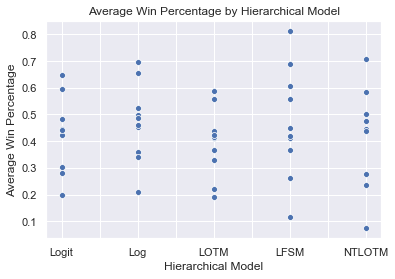

In [17]:
ax = sns.scatterplot(x="Hierarchical Model", y="Average Win Percentage", data=correct_df)
ax.set_title('Average Win Percentage by Hierarchical Model')
x_labels = [x for x in np.linspace(0.5, 5, 10)]
x_labels[1] = 'Logit'
x_labels[3] = 'Log'
x_labels[5] = 'LOTM'
x_labels[7] = 'LFSM'
x_labels[9] = 'NTLOTM'
ax.set_xticklabels(x_labels)

# code to modify xticks taken from here:
# https://stackoverflow.com/questions/38947115/how-to-decrease-the-density-of-x-ticks-in-seaborn
for ind, label in enumerate(ax.get_xticklabels()):
    if (ind + 1) % 2 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

In [164]:
np.median(means_rs_by_hm, axis=0)

array([0.4335    , 0.47483333, 0.41416667, 0.43533333, 0.46      ])

In [136]:
np.mean(means_rs_by_hm, axis=0)

array([0.4244    , 0.46853333, 0.39493333, 0.46936667, 0.4241    ])

In [137]:
np.var(means_rs_by_hm, axis=0)

array([0.01701457, 0.01869154, 0.01441706, 0.03767257, 0.03009231])

In [163]:
scipy.stats.sem(means_rs_by_hm, axis=0)

array([0.04347997, 0.04557233, 0.04002369, 0.06469807, 0.05782379])